In [182]:
%reset -f
import ROOT, math

def get_fis(pb,nev):
    alpha = 0.1
    fac = alpha*pb/2.0
    rdf = ROOT.RDataFrame(int(nev))
    rdf = rdf.Define("phi","gRandom->Rndm()*360")
    rdf = rdf.Define("ihel","gRandom->Rndm()<(0.5+"+str(fac)+"*sin(phi*TMath::DegToRad())) ? 0 : 1")

    hfi0 = rdf.Filter("ihel==0").Histo1D(("hfi0","",24,0,360), "phi")
    hfi1 = rdf.Filter("ihel==1").Histo1D(("hfi1","",24,0,360), "phi")
    return hfi0.GetValue(), hfi1.GetValue()

from collections import defaultdict

nns = defaultdict(list)
#for pb,nev in [(0.16,1e6), (0.8,1e6), (0.55,1e6)]:
for pb,nev in [(0.16,1e6), (0.8,1e6), (0.83,1e6)]:
    hfi0,hfi1 = get_fis(pb,nev)
    for ifi in range(hfi0.GetNbinsX()):
        nns[(ifi,hfi0.GetBinCenter(ifi+1))].append((pb, hfi0.GetBinContent(ifi+1), hfi1.GetBinContent(ifi+1)))

        
def get_asymmetry(nns):
    top,btm,err2 = 0,0,0
    for pb,n0,n1 in nns:
        top += n0/pb - n1/pb
        btm += n0 + n1
    for pb,n0,n1 in nns:
        err2 += n0*math.pow(1/pb*btm - top, 2)
        err2 += n1*math.pow(-1/pb*btm - top, 2)
    err = math.sqrt(err2/math.pow(btm, 4))
    return top/btm, err

gras = defaultdict(lambda: ROOT.TGraphErrors())
for tpl in nns:
    ifi,fi = tpl
    igr=0
    alu,dalu = get_asymmetry(nns[tpl])
    gr = gras[igr]
    gr.SetPoint(gr.GetN(), fi, alu)
    gr.SetPointError(gr.GetN()-1, 0, dalu)
    for it in nns[tpl]:
        igr+=1
        gr = gras[igr]
        alu,dalu = get_asymmetry([it])
        gr.SetPoint(gr.GetN(), fi, alu)
        gr.SetPointError(gr.GetN()-1, 0, dalu)

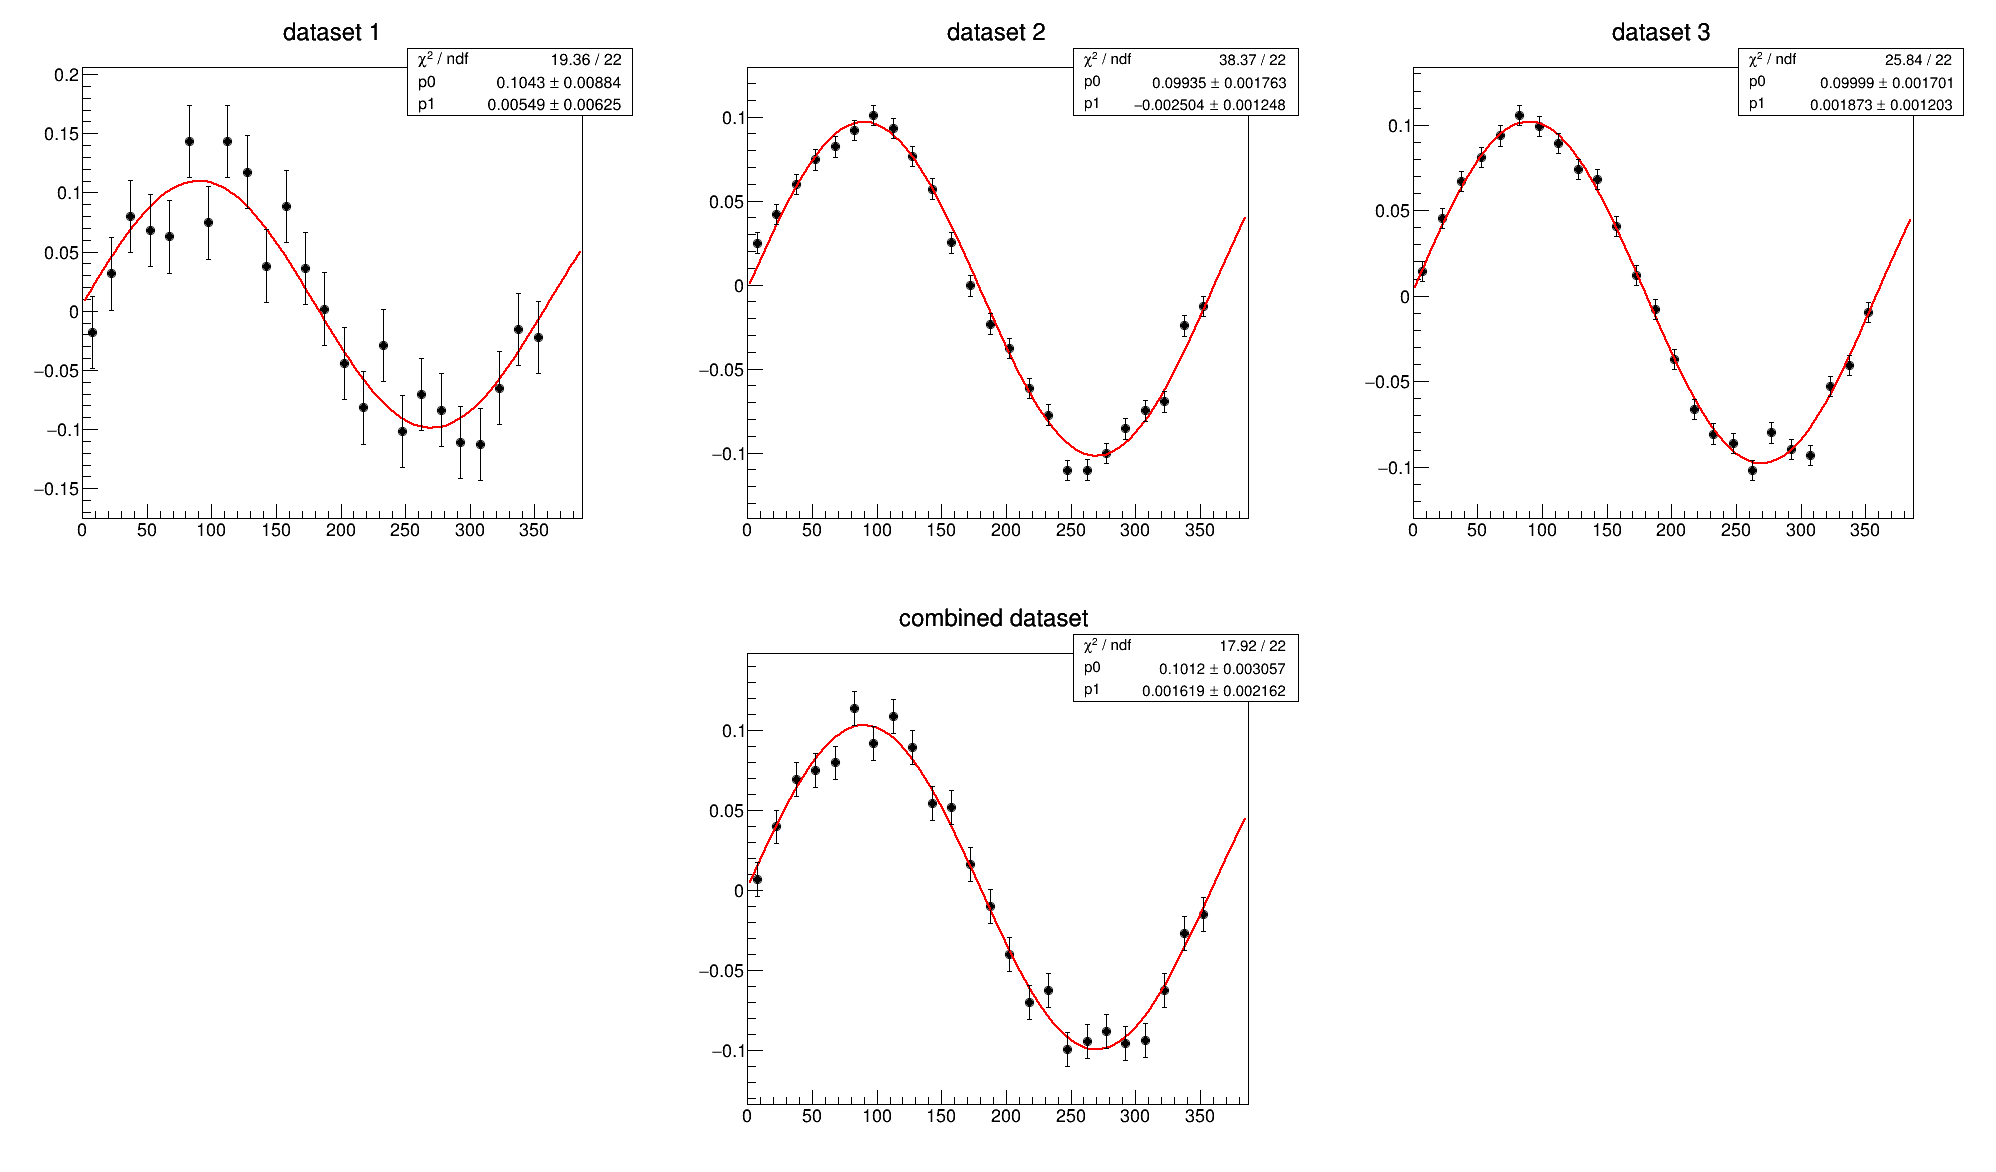

In [188]:
c1 = ROOT.TCanvas("c1","c1",2000,1200)
c1.Divide(3,2)
c1.Draw()

ROOT.gStyle.SetOptFit(1)
for igr in gras:
    c1.cd(igr if igr>0 else 5)
    gr = gras[igr]
    gr.SetMarkerStyle(20)
    f1 = ROOT.TF1("f1","[0]*sin(x*TMath::DegToRad())+[1]",0,1)
    gr.Fit(f1,"Q")
    gr.Draw("AP")
    gr.SetTitle("combined dataset" if igr==0 else "dataset "+str(igr))
